In [ ]:
!pip install --upgrade tensorflow

In [5]:
# Import the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2

In [6]:
#MY KAGGLE API
os.environ["KAGGLE_USERNAME"] = "victoriaolanipekun"
os.environ["KAGGLE_KEY"] = 	"d487a7e9160802ab125541fe0a0d6abb"

In [7]:
# Downloading the dataset directly from Kaggle on the Colab environment 
!kaggle datasets download -d nikitarom/planets-dataset



planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
! unzip /content/planets-dataset.zip

Archive:  /content/planets-dataset.zip
replace planet/planet/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: planet/planet/sample_submission.csv  
replace planet/planet/test-jpg/test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: planet/planet/test-jpg/test_0.jpg  
replace planet/planet/test-jpg/test_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: planet/planet/test-jpg/test_1.jpg  
replace planet/planet/test-jpg/test_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: planet/planet/test-jpg/test_10.jpg  
replace planet/planet/test-jpg/test_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: planet/planet/test-jpg/test_100.jpg  
replace planet/planet/test-jpg/test_1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: planet/planet/test-jpg/test_1000.jpg  
replace planet/planet/test-jpg/test_10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
# Import the dataset
train_classes = pd.read_csv("/content/planet/planet/train_classes.csv")
sample_sub = pd.read_csv("/content/planet/planet/sample_submission.csv")
train_classes.head(5)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
label_list = []
for tag_str in train_classes.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        label_list.append(label)
label_list[:3]

['haze', 'primary', 'agriculture']

In [12]:
# Counts the labels
counts = {}
tags = train_classes['tags'].map(lambda x: x.split(' '))
for labels in tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0
counts

{'agriculture': 12314,
 'artisinal_mine': 338,
 'bare_ground': 861,
 'blooming': 331,
 'blow_down': 100,
 'clear': 28430,
 'cloudy': 2088,
 'conventional_mine': 99,
 'cultivation': 4546,
 'habitation': 3659,
 'haze': 2696,
 'partly_cloudy': 7260,
 'primary': 37512,
 'road': 8070,
 'selective_logging': 339,
 'slash_burn': 208,
 'water': 7410}

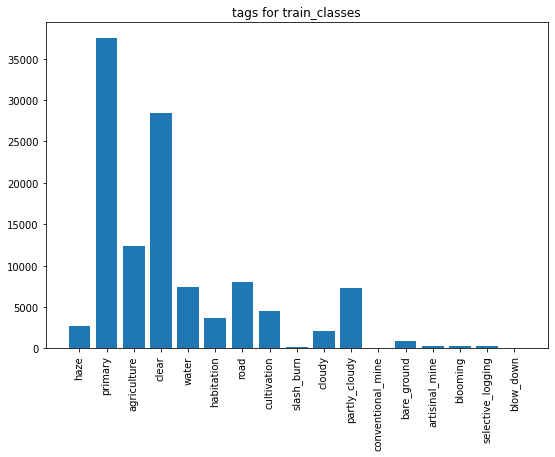

In [13]:
plt.figure(figsize=(9, 6))
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=90)
plt.bar(idxs, counts.values());
plt.title('tags for train_classes');

In [14]:
# Create dictionary list for converting labels to numerical classes

label_list = { counts: name for name, counts in enumerate(counts)}
label_list

{'agriculture': 2,
 'artisinal_mine': 13,
 'bare_ground': 12,
 'blooming': 14,
 'blow_down': 16,
 'clear': 3,
 'cloudy': 9,
 'conventional_mine': 11,
 'cultivation': 7,
 'habitation': 5,
 'haze': 0,
 'partly_cloudy': 10,
 'primary': 1,
 'road': 6,
 'selective_logging': 15,
 'slash_burn': 8,
 'water': 4}

In [15]:
#loading the data
all_labels = tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(train_classes, labels, resize):
    x_train = []
    y_train = []

    label_list = {l: i for i, l in enumerate(labels)}
    inv_label_list= {i: l for l, i in label_list.items()}

    for f, tags in train_classes.values:
        img = cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(f)) 
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_list[t]] = 1 

        x_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    x_train = np.array(x_train, np.float16) / 255.0

    return x_train, y_train


In [16]:
# Reshaping the data
from PIL import Image
from skimage import io
from tensorflow.keras.preprocessing.image import load_img, img_to_array

x, y = load_data(train_classes, labels,resize=(64,64))
print(x.shape)
print(y.shape)



(40479, 64, 64, 3)
(40479, 17)


In [17]:
# check shape of image data
print(train_classes.shape)
print(sample_sub.shape)



(40479, 2)
(61191, 2)


In [18]:
#Spliting the Dataset
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state = 42)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(32383, 64, 64, 3)
(8096, 64, 64, 3)
(32383, 17)
(8096, 17)


In [19]:
# This is a multi label task and labels are given in a single Dataframe Series
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags = train_classes['tags'].str.split()
y = mlb.fit_transform(tags)

labels = mlb.classes_
print('Number of labels: ', len(labels))
print('\n')
print(labels)

Number of labels:  17


['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [20]:
#Importing all layers
from keras import backend as K
from sklearn.metrics import fbeta_score
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from tensorflow.keras.optimizers import Adam


In [21]:
def fbeta(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [22]:
 #this model contains two hidden layer, an input and an output layer
model = keras.Sequential() 
model.add(Conv2D(128, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(17, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = [fbeta])
model.fit(x_train, y_train, epochs = 10, batch_size = 64)
val_loss,val_acc = model.evaluate(x_val, y_val)
print('Tested Acc:', val_acc)

Epoch 1/10
506/506 [==============================] - 83s 161ms/step - loss: 0.2412 - fbeta: 0.5807
Epoch 2/10
506/506 [==============================] - 81s 160ms/step - loss: 0.2106 - fbeta: 0.6273
Epoch 3/10
506/506 [==============================] - 82s 162ms/step - loss: 0.2045 - fbeta: 0.6381
Epoch 4/10
506/506 [==============================] - 87s 173ms/step - loss: 0.1980 - fbeta: 0.6492
Epoch 5/10
506/506 [==============================] - 81s 160ms/step - loss: 0.1946 - fbeta: 0.6570
Epoch 6/10
506/506 [==============================] - 81s 160ms/step - loss: 0.1923 - fbeta: 0.6609
Epoch 7/10
506/506 [==============================] - 81s 160ms/step - loss: 0.1898 - fbeta: 0.6659
Epoch 8/10
506/506 [==============================] - 81s 160ms/step - loss: 0.1860 - fbeta: 0.6723
Epoch 9/10
506/506 [==============================] - 81s 159ms/step - loss: 0.1822 - fbeta: 0.6801
Epoch 10/10
253/253 [==============================] - 6s 24ms/step - loss: 0.1776 - fbeta: 0.7063
T

In [23]:
import gc
gc.collect()

1374

In [26]:
# Evaluate the model on x_val dataset
from sklearn.metrics import fbeta_score
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): {}".format(score))
print("Error: {}".format(100-score*100))

Test score (f1): 0.7677077596174432
Error: 23.22922403825568


In [27]:
test_loss, test_accuracy = model.evaluate(x_val, y_val)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))



253/253 [==============================] - 307s 1s/step - loss: 0.2202 - fbeta: 0.5965
Test loss: 0.22015425562858582
Test accuracy: 0.5964882373809814


In [28]:
gc.collect()

5672

In [29]:
#Testing the model on Test data
from tqdm import tqdm 
X_test=[]

for img, label in tqdm(sample_sub[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))

for img, label in tqdm(sample_sub[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))

x_test = np.array(X_test, np.float16)/255.0

100%|██████████| 20522/20522 [00:33<00:00, 617.27it/s]


In [30]:
x_test.shape



(61191, 64, 64, 3)

In [31]:
Test_pred = model.predict(x_test, batch_size = 64)



In [32]:
gc.collect()

1017

In [33]:
Test_pred

array([[0.01137447, 0.08735406, 0.07323402, ..., 0.12412626, 0.7518034 ,
        0.03907153],
       [0.01169023, 0.08586183, 0.08697969, ..., 0.15189189, 0.80290264,
        0.03935182],
       [0.04619774, 0.19807202, 0.2046602 , ..., 0.53583086, 0.29097968,
        0.18401405],
       ...,
       [0.01751074, 0.1061911 , 0.13232619, ..., 0.26192573, 0.72400606,
        0.06992695],
       [0.01093879, 0.09194764, 0.0711593 , ..., 0.12137187, 0.5910964 ,
        0.04899168],
       [0.03810099, 0.15783   , 0.3650223 , ..., 0.6984886 , 0.50359243,
        0.24319407]], dtype=float32)

In [34]:
#CREATING A DATAFRAME OF PREDICTIONS WITH ASSOCIATED LABELS
prediction = pd.DataFrame(Test_pred, columns= labels)



In [35]:
final_prediction = []

for i in tqdm(range(prediction.shape[0]), miniters=1000):
    a = prediction.loc[[i]]
    a = a.apply(lambda x:x>0.2, axis =1)
    a = a.transpose()
    a = a.loc[a[i]==True]
    ' '.join(list(a.index))
    final_prediction.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [02:13<00:00, 457.51it/s]


In [37]:
#My Kaggle Submission

In [38]:
#CREATING A SUBMISSION CSV FILE
sample_sub['tags'] = final_prediction
sample_sub.to_csv('My_Kaggle_submission.csv', index = False)
